## Using the KR Swaps stereochemistry correction algorithm to modify a RetroTide PKS design for maximal stereochemistry correspondence between the corresponding PKS product and a user-defined target molecule.
### December 11, 2025

In [19]:
from typing import List, Optional
from rdkit import Chem
import bcs
import warnings
warnings.filterwarnings('ignore') # ignore 'product atom-mapping number 10 not found in reactants' warnings

### Here, we will use the bcs (w/ the stereospecific KR, DH, and ER domains) and retrotide packages to intitialize KR Swaps with the predicted type I PKS design and PKS product based on an inputted target molecule. Then, we will go over how KR Swaps is able to make reductive loop swaps in silico and output a modified PKS design that produces a 3D PKS product with maximal structure and stereochemistry correspondence with the target.

Note: To run RetroTide + KR Swaps, all you need to do is change the paramerters in config.yaml dependent on the target molecule of interest and run run_stereocorrection.py. From doing so, you will get two .svg files, showing the stereochemistry correspondence between the predicted PKS product and target pre and post stereochemistry correction by KR Swaps. Results such as the corrected PKS design and product will be stored in an additional .json file.

This notebook is if you want more insight into how the KR Swaps algorithm works! We provide an example using narbonolide as the target molecule.

### Example: Narbonolide

In [2]:
target_smi = 'CC[C@H]1OC(=O)[C@H](C)C(=O)[C@H](C)[C@@H](O)[C@@H](C)C[C@@H](C)C(=O)/C=C/[C@H]1C'

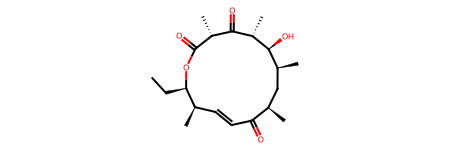

In [3]:
# Canonoicalize target SMILES and specify the stereochemistry to consider
def canonicalize_smiles(molecule_smi: str, stereo: str) -> str:
    """
    Standardizes a SMILES string and returns its canonical form with the
    specified isomeric information.

    Args:
        molecule_smi (str): The SMILES string of the target molecule
        stereo (str): The type of stereochemistry to specify

    Returns:
        target (str): The canonicalized target SMILES string
    """
    mol = Chem.MolFromSmiles(molecule_smi)
    if stereo == 'R/S':
        target = Chem.MolToSmiles(mol, isomericSmiles=True).replace('/', '').replace('\\', '')
    elif stereo == 'E/Z':
        target = Chem.MolToSmiles(mol, isomericSmiles=True).replace('@', '').replace('@@', '')
    elif stereo == 'none':
        target = Chem.MolToSmiles(mol, isomericSmiles=False)
    elif stereo == 'all':
        target = Chem.MolToSmiles(mol, isomericSmiles=True) 
    else:
        raise ValueError("Invalid stereo option. Choose from 'R/S', 'E/Z', 'none', or 'all'.")
    return target

# KR Swaps handles both R/S and E/Z stereochemistry. Let's select 'all' to consider both.
target_smi = canonicalize_smiles(target_smi, stereo='all')

# Here is what the 3D target molecule looks like
target_mol = Chem.MolFromSmiles(target_smi)
target_mol

In [4]:
# Let's run RetroTide to retrosynthetically predict the type I PKS that makes the 2D target structure
def modify_bcs_starters_extenders(starter_codes: Optional[List[str]] = None,
                                  extender_codes: Optional[List[str]] = None):
    """
    Modifies the starter and extender units available for RetroTide.
    Removes all starter and extender units not specifed in the input lists.
    """
    for key in list(bcs.starters.keys()):
        if key not in starter_codes:
            bcs.starters.pop(key, None)
    for key in list(bcs.extenders.keys()):
        if key not in extender_codes:
            bcs.extenders.pop(key, None)

modify_bcs_starters_extenders(starter_codes = ['prop'],
                              extender_codes = ['Malonyl-CoA', 'Methylmalonyl-CoA'])

from retrotide import structureDB, designPKS, compareToTarget

def initial_pks(target_smi: str) -> tuple[list, Chem.Mol]:
    """
    Computes a PKS design to synthesize the 2D structure of the target molecule

    Args:
        target (str): The SMILES string of the target molecule

    Returns:
        pks_design (list): Initial RetroTide proposed PKS design
        mol (Chem.Mol): The computed PKS product of the PKS design
    """
    designs = designPKS(Chem.MolFromSmiles(target_smi),
                        maxDesignsPerRound = 500, # this is a tunable parameter
                        similarity = 'mcs_without_stereo')
    pks_design = designs[-1][0][0].modules
    mol = designs[-1][0][0].computeProduct(structureDB)
    return pks_design, mol

pks_design, mol = initial_pks(target_smi)









































































["AT{'substrate': 'Malonyl-CoA'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", "DH{'type': 'E'}", "ER{'type': 'L'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", "DH{'type': 'E'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", "DH{'type': 'Z'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", "DH{'type': 'E'}", "ER{'type': 'D'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'B'}", "DH{'type': 'E'}", "ER{'type': 'L'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'A2'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B2'}", 'loading: False']
["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'A1'}", 'loading: False']
["AT{'substrate': 'Malonyl-CoA'}"

In [5]:
# RetroTide PKS design for Narbonolide
pks_design

[["AT{'substrate': 'prop'}", 'loading: True'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'A2'}", 'loading: False'],
 ["AT{'substrate': 'Malonyl-CoA'}", "KR{'type': 'A'}", "DH{'type': 'Z'}", 'loading: False'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'C1'}", 'loading: False'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'B1'}", "DH{'type': 'E'}", "ER{'type': 'L'}", 'loading: False'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'A2'}", 'loading: False'],
 ["AT{'substrate': 'Methylmalonyl-CoA'}", "KR{'type': 'C1'}", 'loading: False']]

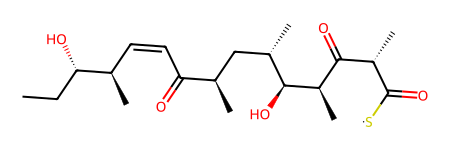

In [6]:
# PKS product with stereochemistry dictated by the KR, DH, and ER domain subytpes initially proposed by RetroTide
mol

### The resulting PKS design and PKS product are passed to the stereochemistry correction algorithm KR Swaps.

### 1. Get the module mapped offloaded PKS product

In [7]:
from krswaps import krswaps as krs
# Extract PKS design features
pks_features = krs.get_design_features(pks_design)

# Map each atom in the PKS product to the PKS module it was added or transformed by
# See nb_02_PKS_atom_mapping notebook for details
mapped_product = krs.module_map_product(pks_design)

# Offload the module mapped product by "breaking" the thioester bond that keeps the PKS product tethered to the ACP domain
# To form this macrolide product, we need to cyclize the offloaded product. The other option is 'thiolysis' which yields a linear product with a terminal carboxylic acid group.
unbound_mol = krs.te_offload(mapped_product, target_mol, 'cyclization')[0]

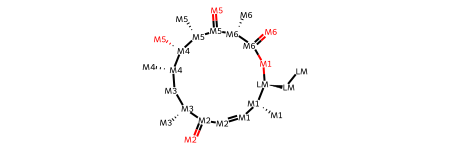

In [8]:
# Now each PKS product atom is labeled with the PKS module it was added or transformed by
unbound_mol

### 2. Get a PKSable target

#### Calculating the structural similarity between the offloaded PKS product and the target molecule tells us whether the target molecule can be synthesized by a PKS alone or if post-PKS modifications are requried to reach the final target. If the maximum common substructure (MCS) similarity is < 1, the target PKS precursor (the part of the target molecule that is "PKSable") is extracted and set as the target going forward.

In [9]:
target_mol, mcs_score = krs.get_pks_target(unbound_mol, target_mol)
print(f'MCS similarity between the PKS product and target molecule: {mcs_score:.2f}')

MCS similarity between the PKS product and target molecule: 1.00


### 3. Atom and module map the PKS product

#### To directly compare the PKS product to the target and assess the absolute stereochemistry correspondence, each atom in the PKS product is mapped to each atom in the target based on structural correspondence found using an MCS search. The PKS product atom and module mapping is tracked in a pandas dataframe.

In [10]:
mapping_df = krs.full_map(krs.atom_map(unbound_mol, target_mol), krs.module_map(unbound_mol))
mapping_df

,Atom Type,Product Atom Idx,Target Atom Idx,Module Idx
0,C,0,0,LM
1,C,1,1,LM
2,C,2,2,LM
3,C,3,23,M1
4,C,5,22,M1
5,C,7,21,M2
6,C,8,19,M2
7,C,9,17,M3
8,C,11,16,M3
9,C,13,14,M4


### 4. Assess the initial stereochemistry correspondence

#### This mapping infromation is used to check the R/S and E/Z stereochemistry correspondence between the offloaded PKS product and target molecule. This is done by comparing the absolute stereochemistry descriptors for each stereocenter present in both the PKS product and target molecule and keeping track of matching and mismatching stereocenter indices for each molecule, respectively.

In [11]:
Chem.AssignStereochemistry(unbound_mol, cleanIt=True, force=True)

chiral_result = krs.get_rs_stereo_correspondence(unbound_mol, target_mol, mapping_df)
alkene_result = krs.get_ez_stereo_correspondence(unbound_mol, target_mol, mapping_df)

print(f'PKS Matches: {chiral_result.match1}, {alkene_result.match1}')
print(f'Target Matches: {chiral_result.match2}, {alkene_result.match2}')

print(f'PKS Mismatches: {chiral_result.mmatch1}, {alkene_result.mmatch1}')
print(f'Target Mismatches: {chiral_result.mmatch2}, {alkene_result.mmatch2}')

PKS Matches: [3, 9, 13, 14], []
Target Matches: [23, 17, 14, 12], []
PKS Mismatches: [2, 16, 20], [5, 7]
Target Mismatches: [2, 10, 6], [22, 21]


#### Here is what the initial stereochemistry correspondence looks like. Matching and mismatching stereocenters are highlighted blue and red, respectively.

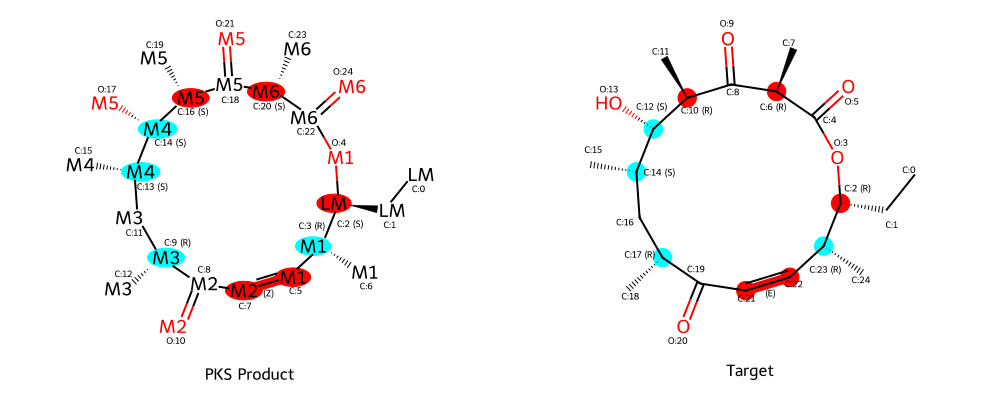

In [12]:
krs.visualize_stereo_correspondence(unbound_mol, target_mol, chiral_result, alkene_result)

### 5. Get PKS backbone pairs

#### KR Swaps works by evaluating pairs of backbone carbons that are mapped to sequential PKS modules. Each PKS module at most sets the stereochemistry of two stereocenters (alpha and beta). This step ensures the alpha and beta stereocenters set by the same PKS module end up in the same backbone pair. The module responsible for the alpha and beta carbon stereochemistry is the higher ordered module of that pair (Mi+1).

In [13]:
backbone_pairs = krs.extract_carbon_pairs(unbound_mol, mapping_df)
backbone_pairs

[((2, 'LM'), (3, 'M1')),
 ((5, 'M1'), (7, 'M2')),
 ((8, 'M2'), (9, 'M3')),
 ((11, 'M3'), (13, 'M4')),
 ((14, 'M4'), (16, 'M5')),
 ((18, 'M5'), (20, 'M6'))]

#### A pattern substructure search is used to identify alpha and beta carbons. Then, we cross reference information about each backbone pair with the atom indices of mismatched chiral centers to determine whether the alpha and/or beta chiral center is mismatched.

In [14]:
cc_mismatches = krs.check_cc_mismatch_cases(unbound_mol, backbone_pairs, chiral_result.mmatch1)
cc_mismatches

[{'c_idx_i': 2,
  'module_i': 'LM',
  'c_idx_i+1': 3,
  'module_i+1': 'M1',
  'alpha_mismatch': False,
  'beta_mismatch': True},
 {'c_idx_i': 14,
  'module_i': 'M4',
  'c_idx_i+1': 16,
  'module_i+1': 'M5',
  'alpha_mismatch': True,
  'beta_mismatch': False},
 {'c_idx_i': 18,
  'module_i': 'M5',
  'c_idx_i+1': 20,
  'module_i+1': 'M6',
  'alpha_mismatch': True,
  'beta_mismatch': False}]

#### This processes is repeated to check for alkene stereochemistry mismatches. Alkene stereochemistry is set by the DH domain. However, the DH domain subtype is specific to the beta-hydroxyl stereochemistry set by the KR domain of the same module. Thus, the alkene stereochemistry is a product of the DH-KR combo.

In [15]:
alkene_mismatches = krs.check_alkene_mismatch_cases(unbound_mol, backbone_pairs, alkene_result.mmatch1)
alkene_mismatches

[{'c_idx_i': 5,
  'module_i': 'M1',
  'c_idx_i+1': 7,
  'module_i+1': 'M2',
  'alkene_mismatch': True}]

### 6. Logically make targeted reductive loop swaps

### KR Swaps is equipped to handle seven different cases of stereochemistry mismatches. In each case, KR Swaps uses the old reductive loop subtypes along with the mismatch information for each backbone pair to logically determine what the correct subtypes should be, and make targeted reductive loop swaps in the PKS modules responsible for these mismatches.

In [16]:
krs_result = krs.kr_swaps_algorithm(unbound_mol,
                                    target_mol,
                                    mapping_df,
                                    pks_features,
                                    'cyclization',
                                    chiral_result,
                                    alkene_result)

Correcting R/S stereochemistry
----Analyzing mismatch(s) in pair (2, 3)----
    alpha_mismatch: False, beta_mismatch: True
    Case 2: Only beta is wrong -> swapping letter only
    Making KR swap in module 1: Type A2 -> Type B2
----Analyzing mismatch(s) in pair (14, 16)----
    alpha_mismatch: True, beta_mismatch: False
    Case 3: Only alpha is wrong -> swapping number only
    Making KR swap in module 5: Type A2 -> Type A1
----Analyzing mismatch(s) in pair (18, 20)----
    alpha_mismatch: True, beta_mismatch: False
    Case 3: Only alpha is wrong -> swapping number only
    Making KR swap in module 6: Type C1 -> Type C2
Correcting E/Z stereochemistry
----Analyzing alkene mismatch(s) in pair (5, 7)----
    alkene mismatch: True
    Case 6: Swapping DH-KR subtypes
    Making DH-KR swap in module 2: Z-A -> E-B


### 7. Reconstruct the PKS design with the new reductive loop subtypes

In [17]:
new_design = krs_result.pks_design
for module in new_design:
    print(module)

['M0', 'AT Substrate: prop', 'Reductive Loop: None']
['M1', 'AT Substrate: Methylmalonyl-CoA', 'Reductive Loop: KR(B2)']
['M2', 'AT Substrate: Malonyl-CoA', 'Reductive Loop: DH(E)-KR(B)']
['M3', 'AT Substrate: Methylmalonyl-CoA', 'Reductive Loop: KR(C1)']
['M4', 'AT Substrate: Methylmalonyl-CoA', 'Reductive Loop: DH(E)-ER(L)-KR(B1)']
['M5', 'AT Substrate: Methylmalonyl-CoA', 'Reductive Loop: KR(A1)']
['M6', 'AT Substrate: Methylmalonyl-CoA', 'Reductive Loop: KR(C2)']


### 8. Assess the stereochemistry correspondence post stereocorrection by KR Swaps

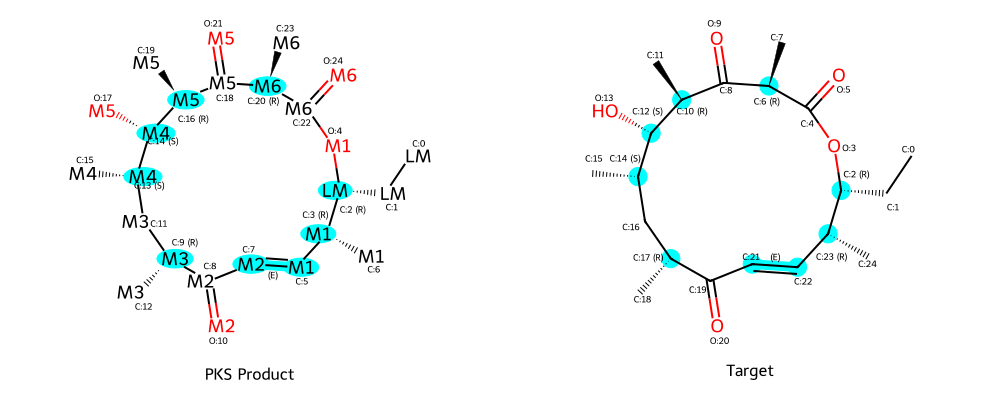

In [18]:
krs.visualize_stereo_correspondence(krs_result.pks_product, target_mol, krs_result.chiral_result, krs_result.alkene_result)